In [1]:
import wandb
import torch
from torch.utils.data import DataLoader
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from oa.model import RegressionTCNv0
from oa.dataset import TempDataset

In [2]:
import wandb

# project_name = "tcn_lite"
# run_path = "becklabs-northeastern-university/tcn_lite/eqblf3xq"

project_name = "tcn_sample"
run_path = "becklabs-northeastern-university/tcn_sample/abg2vxi7"

api = wandb.Api()
run = api.run(run_path)

checkpoint_path = run.file(f"training_checkpoints/{project_name}/model_epoch_0.pth").download(replace=True).name
# X_scaler_path = run.file(f"training_checkpoints/{project_name}/X_scaler.pkl").download(replace=True).name
# X_scaler_path = run.file(f"training_checkpoints/{project_name}/y_scaler.pkl").download(replace=True).name

#### Load validation data

In [3]:
data_dir = "../data/"
# X = np.load(data_dir + "preprocessed/temperature/X_lite.npy")  # (nx, nt, 20, 6)
# y = np.load(data_dir + "preprocessed/temperature/y_lite.npy")  # (nx, nt, 3)

X = np.load(data_dir + "preprocessed/temperature/sample/X.npy")  # (nx, nt, 20, 6)
y = np.load(data_dir + "preprocessed/temperature/sample/y.npy")  # (nx, nt, 3)

nx, nt, _, _ = X.shape

# Withhold 3 random points for validation
n_val_points = 10
np.random.seed(42)
val_inds = np.random.choice(nx, n_val_points, replace=False)
X_val = X[val_inds]
y_val = y[val_inds]

X = np.delete(X, val_inds, axis=0)
y = np.delete(y, val_inds, axis=0)

# Flatten
nx, nt, window_size, n_feats = X.shape
nx, nt, n_labels = y.shape
X = X.reshape(nx * nt, window_size, n_feats)
y = y.reshape(nx * nt, n_labels)

num_samples = y.shape[0]

# Split data into training and testing sets
p = 0.8
train_inds = np.random.choice(num_samples, int(num_samples * p), replace=False)
test_inds = np.arange(num_samples)[~np.isin(np.arange(num_samples), train_inds)]

X_train = X[train_inds]
y_train = y[train_inds]

X_test = X[test_inds]
y_test = y[test_inds]
# _dataset = TempDataset(X_train, y_train)
# X_scaler = _dataset.X_scaler
# y_scaler = _dataset.y_scaler

In [4]:
loss_delay = 0
network_depth = 6
filter_width = 4
# hidden_channels = [64, 128, 256, 512, 512, 256, 128, 64]
hidden_channels = [64, 64, 64, 64, 64, 64]
dropout = 0
output_dim = 3

feature_dim = 9
activation = 'relu'
use_skip_connections = False

model = RegressionTCNv0(
    feature_dim=feature_dim,
    output_dim=output_dim,
    hidden_channels=hidden_channels,
    network_depth=network_depth,
    filter_width=filter_width,
    dropout=dropout,
    activation=activation,
    use_skip_connections=use_skip_connections
)

# checkpoint_dir = "../training_checkpoints/tcn_lite/"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

X_scaler = checkpoint['X_scaler']
y_scaler = checkpoint['y_scaler']

/var/folders/yt/5bbs78k15qd494t52z63npmm0000gn/T/ipykernel_33707/1136868414.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

#### Load validation data

In [5]:
# Flatten
device = "mps"
model.eval()
model.to(device)

RegressionTCNv0(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 64, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          64, 64, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
        (downsample): Conv1d(9, 64, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          64, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametrizations):

#### Test set loss

In [36]:
dataset = TempDataset(X = X_test, y = y_test, X_scaler=X_scaler, y_scaler=y_scaler, device = device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
y_actual = []
y_preds = []
for i, (X, y) in enumerate(dataloader):
    with torch.no_grad():
        y_pred = model(X)
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_scaler.inverse_transform(y_pred)
    y = y.detach().cpu().numpy()
    y = y_scaler.inverse_transform(y)
    y_actual.append(y)
    y_preds.append(y_pred)
y_actual = np.array(y_actual).reshape(-1, 3)
y_preds = np.array(y_preds).reshape(-1, 3)

KeyboardInterrupt: 

In [16]:
print("Mean temperature RMSE", np.sqrt(np.mean((y_actual[:, 0] - y_preds[:, 0])**2)))
print("Mean temperature MAE", np.mean(np.abs(y_actual[:, 0] - y_preds[:, 0])))

print("PCA 1 RMSE", np.sqrt(np.mean((y_actual[:, 1] - y_preds[:, 1])**2)))
print("PCA 1 MAE", np.mean(np.abs(y_actual[:, 1] - y_preds[:, 1])))

print("PCA 2 RMSE", np.sqrt(np.mean((y_actual[:, 2] - y_preds[:, 2])**2)))
print("PCA 2 MAE", np.mean(np.abs(y_actual[:, 2] - y_preds[:, 2])))

Mean temperature RMSE 2.1890302
Mean temperature MAE 1.9863611
PCA 1 RMSE 3.1742756
PCA 1 MAE 3.1504033
PCA 2 RMSE 0.26992956
PCA 2 MAE 0.25687584


#### Validation points

In [6]:
from oa.utils import load_mat
from oa.preprocessing.preprocessing import reconstruct_T

phi = np.load(data_dir + 'preprocessed/temperature/sample/phi.npy')
phi = phi[val_inds]

T = np.load(data_dir + "preprocessed/temperature/sample/T.npy")  # (nx, nz, nt)
T = T[val_inds]

In [7]:
T.shape

(10, 3249, 45)

In [10]:
val_inds

array([120, 416, 334, 350, 412, 554,  76, 314, 247, 338])

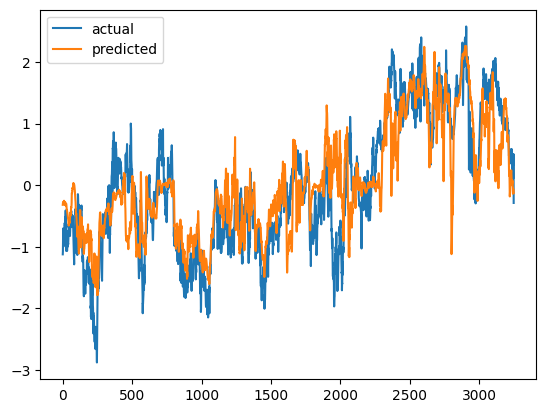

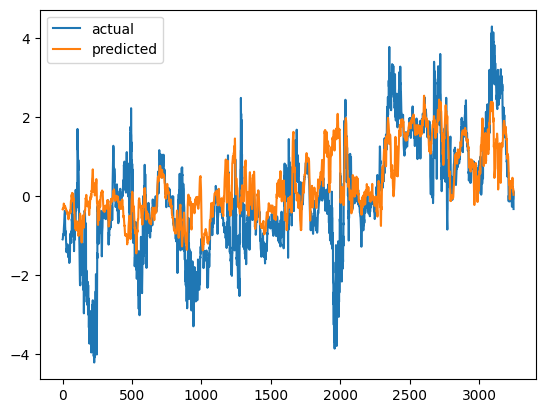

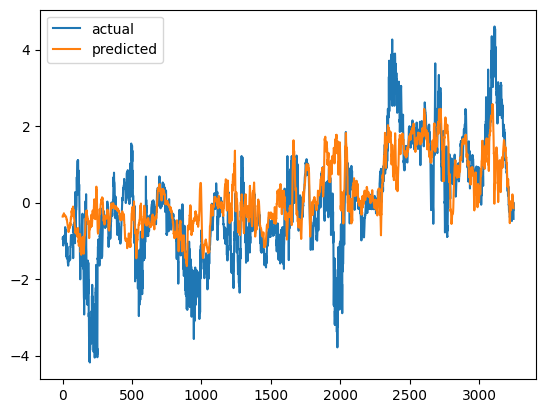

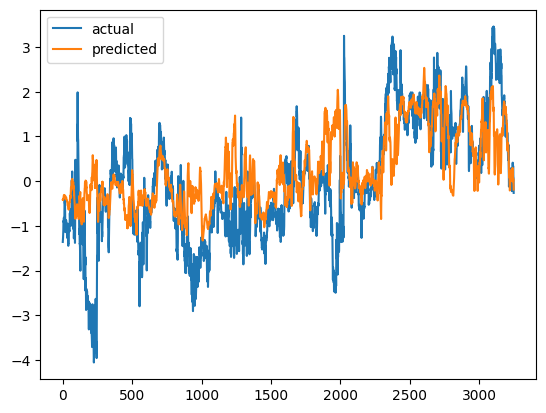

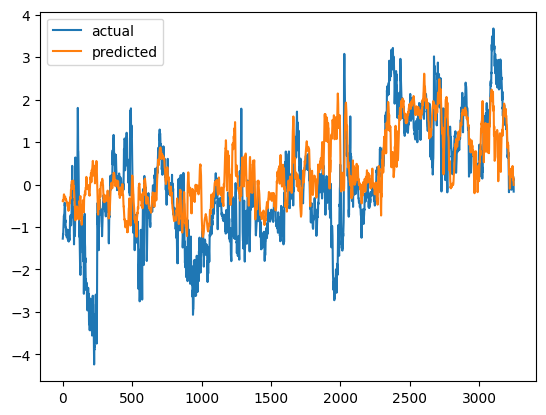

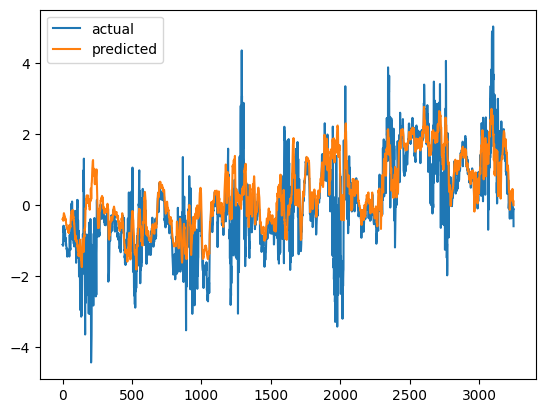

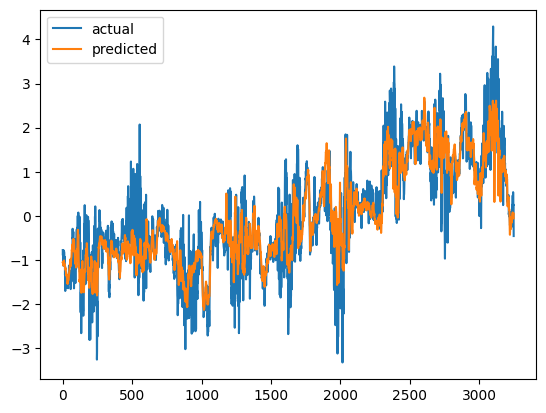

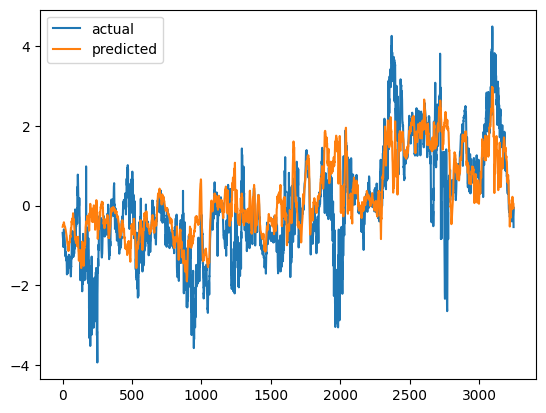

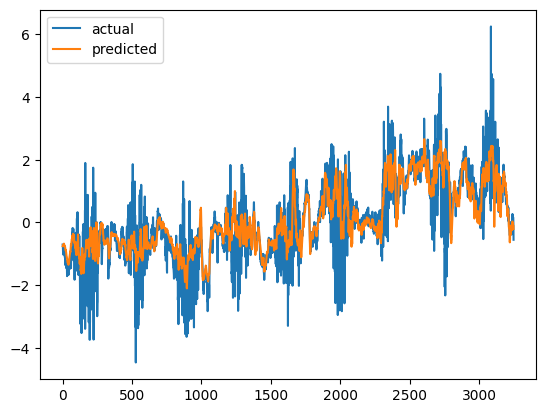

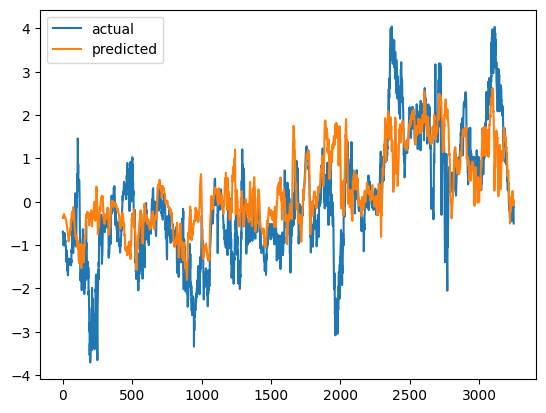

In [18]:
pred_T_all = []
actual_T_all = []
val_T_all = []
for val_ind, (val_X, val_y) in enumerate(zip(X_val, y_val)):
    dataset = TempDataset(X = val_X, y = val_y, X_scaler=X_scaler, y_scaler=y_scaler, device = device)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    y_actual = []
    y_preds = []
    for i, (X, y) in enumerate(dataloader):
        with torch.no_grad():
            y_pred = model(X)
        y_pred = y_pred.detach().cpu().numpy()
        y_pred = y_scaler.inverse_transform(y_pred)
        y = y.detach().cpu().numpy()
        y = y_scaler.inverse_transform(y)
        y_actual.append(y)
        y_preds.append(y_pred)
    y_actual = np.array(y_actual).reshape(-1, 3)
    y_preds = np.array(y_preds).reshape(-1, 3)

    T_bar = y_preds[:, 0]
    q = y_preds[:, 1:]
    pred_T = reconstruct_T(phi[val_ind][np.newaxis, :], q[np.newaxis, :], T_bar[np.newaxis, :])

    T_bar = y_actual[:, 0]
    q = y_actual[:, 1:]
    actual_T = reconstruct_T(phi[val_ind][np.newaxis, :], q[np.newaxis, :], T_bar[np.newaxis, :])

    T_bar = val_y[:, 0]
    q = val_y[:, 1:]
    val_T = reconstruct_T(phi[val_ind][np.newaxis, :], q[np.newaxis, :], T_bar[np.newaxis, :])

    pred_T_all.append(pred_T)
    actual_T_all.append(actual_T)
    val_T_all.append(val_T)

    fig, ax = plt.subplots()
    ax.plot(actual_T[0,:,45//2], label='actual')
    ax.plot(pred_T[0,:,45//2], label='predicted')
    ax.legend() 

In [20]:
pred_T_all = np.array(pred_T_all)[:, 0, :, :]
actual_T_all = np.array(actual_T_all)[:, 0, :, :]
val_T_all = np.array(val_T_all)[:, 0, :, :]

In [13]:
torch.functional.F.mse_loss(torch.tensor(pred_T_all), torch.tensor(actual_T_all))

tensor(0.7917, dtype=torch.float64)

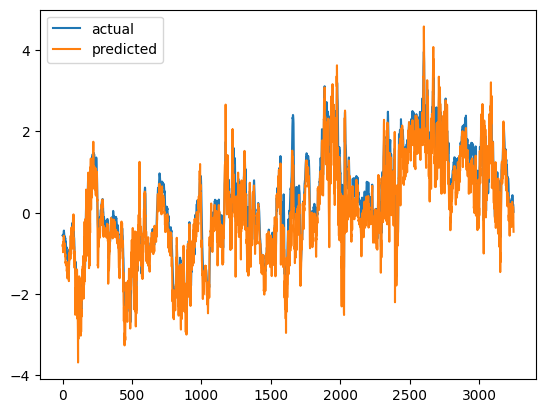

In [22]:
fig, ax = plt.subplots()
ax.plot(pred_T_all[2, :, 0], label='actual')
ax.plot(T[2, :, 0], label='predicted')
ax.legend() 

In [14]:
T.shape, pred_T_all.shape
np.sqrt(np.mean((T[2] - actual_T_all[2])**2))

6.26024606279549e-08

In [15]:
print("Mean temperature RMSE", np.sqrt(np.mean((y_actual[:, 0] - y_preds[:, 0])**2)))
print("Mean temperature MAE", np.mean(np.abs(y_actual[:, 0] - y_preds[:, 0])))

print("PCA 1 RMSE", np.sqrt(np.mean((y_actual[:, 1] - y_preds[:, 1])**2)))
print("PCA 1 MAE", np.mean(np.abs(y_actual[:, 1] - y_preds[:, 1])))

print("PCA 2 RMSE", np.sqrt(np.mean((y_actual[:, 2] - y_preds[:, 2])**2)))
print("PCA 2 MAE", np.mean(np.abs(y_actual[:, 2] - y_preds[:, 2])))

Mean temperature RMSE 0.8614855
Mean temperature MAE 0.61037457
PCA 1 RMSE 2.4603162
PCA 1 MAE 1.7571182
PCA 2 RMSE 1.5626174
PCA 2 MAE 1.125027
